## Explanation Analysis Synthetic
This Notebook is designed to generate the explanations for the origins of uncertainty for the Synthetic data set

In [3]:
import numpy as np
import pandas as pd
import torch
import os
from models.gaussian_history_only_network import GaussianHistoryNetwork, create_gaussian_history_predictions
from models.quantile_history_only_network import QuantileHistoryNetwork,create_quantile_history_predictions

from pipelines.preprocessing_pipeline import prep_data_exogenous_no_temporal
from metrics.evaluation_functions_synthetic import create_prediction_plot, create_prediction_plot_quantile, create_stacked_explainations, compare_mean_scaled_attributions, plot_scaled_attribute_sample, plot_mean_specific_time, quantile_explain_plot_sample, gaussian_explaination_plot_sample
from captum.attr import Saliency, IntegratedGradients, FeatureAblation, FeaturePermutation, ShapleyValueSampling
import tomlkit

In [26]:
with open('../configs/synthetic_config.toml', 'rb') as f:
    configs = tomlkit.load(f)

### Select Config and load models
The first step is to select the configuration we use and to load the appropriate models that have already been trained

In [27]:
# Select config to use
config = configs['Config1']

In [28]:
num_points = config['num_points']
base_amplitude = config['base_amplitude']
base_frequency = config['base_frequency']
base_noise_scale = config['base_noise_scale']
base_noise_amplitude = config['base_noise_amplitude']
num_trend_events = config['num_trend_events']
trend_parameters = config['trend_parameters']
num_cosine_events = config['num_cosine_events']
cosine_frequency_params = config['cosine_frequency_params']
cosine_amplitude_params = config['cosine_amplitude_params']
num_increased_noise_events = config['num_increased_noise_events']
increased_noise_params = config['increased_noise_params']
test_size = config['test_size']
number_of_features = config['number_of_features']
hidden_size_history = config['hidden_size_history']
learning_rate_history = config['learning_rate_history']
learning_rate_exog = config['learning_rate_exog']
hidden_size_exog = config['hidden_size_exog']
hidden_size_exog_hi = config['hidden_size_exog_hi']
num_epochs = config['num_epochs']
batch_size = config['batch_size']
quantiles = config['quantiles']
save_path = config['save_path']
save_path_data = f"{save_path}data/"
save_path_crps = f"{save_path}crps/"
save_history_name = config['save_history_name']
save_exog_name = config['save_exog_name']
descriptor = config['descriptor']
save_history_name = f"{save_history_name}_{descriptor}.pt"
save_exog_name = f"{save_exog_name}_{descriptor}.pt"
forecast_horizon = 20
history_length = 40

In [29]:
df = pd.read_csv(f"../{save_path_data}{descriptor}_data.csv", index_col="Unnamed: 0")

In [30]:
target_train, target_test, history_train, history_test, feature1_train, feature1_test, feature2_train, \
    feature2_test, feature3_train, feature3_test, target_scaler, history_scaler, feature1_scaler, \
    feature2_scaler, feature3_scaler = prep_data_exogenous_no_temporal(
    df=df,
    target_var='Target',
    feature1_var='Trend',
    feature2_var='Cosine',
    feature3_var='Noise',
    history_length=history_length,
    forecast_horizon=forecast_horizon,
    test_size=test_size)

In [31]:
model_history = GaussianHistoryNetwork(input_size=history_length,
                                       hidden_size=hidden_size_history,
                                       output_size=forecast_horizon)
model_history.load_state_dict(torch.load(f"../{save_path}models/Gaussian_{save_history_name}"))

<All keys matched successfully>

In [32]:
quantile_model_dict = dict()
quantile_predictions_dict = dict()
for q in quantiles:
    quantile_model_history = QuantileHistoryNetwork(input_size=history_length,
                                                            hidden_size=hidden_size_history,
                                                            output_size=forecast_horizon,
                                                            quantile=q)
    quantile_model_history.load_state_dict(torch.load(f"../{save_path}models/Quantile{q}_{save_history_name}"))
    quantile_model_dict[q] = quantile_model_history
    quantile_predictions_dict[q] = create_quantile_history_predictions(model=quantile_model_history,
                                                                       X_test=history_test)

In [33]:
mu_test_history, logvar_test_history = create_gaussian_history_predictions(model=model_history,
                                                                           X_test=history_test)

### Calculate CRPS and plot predictions
The next step is to calculate the CRPS and plot some prediction intervals

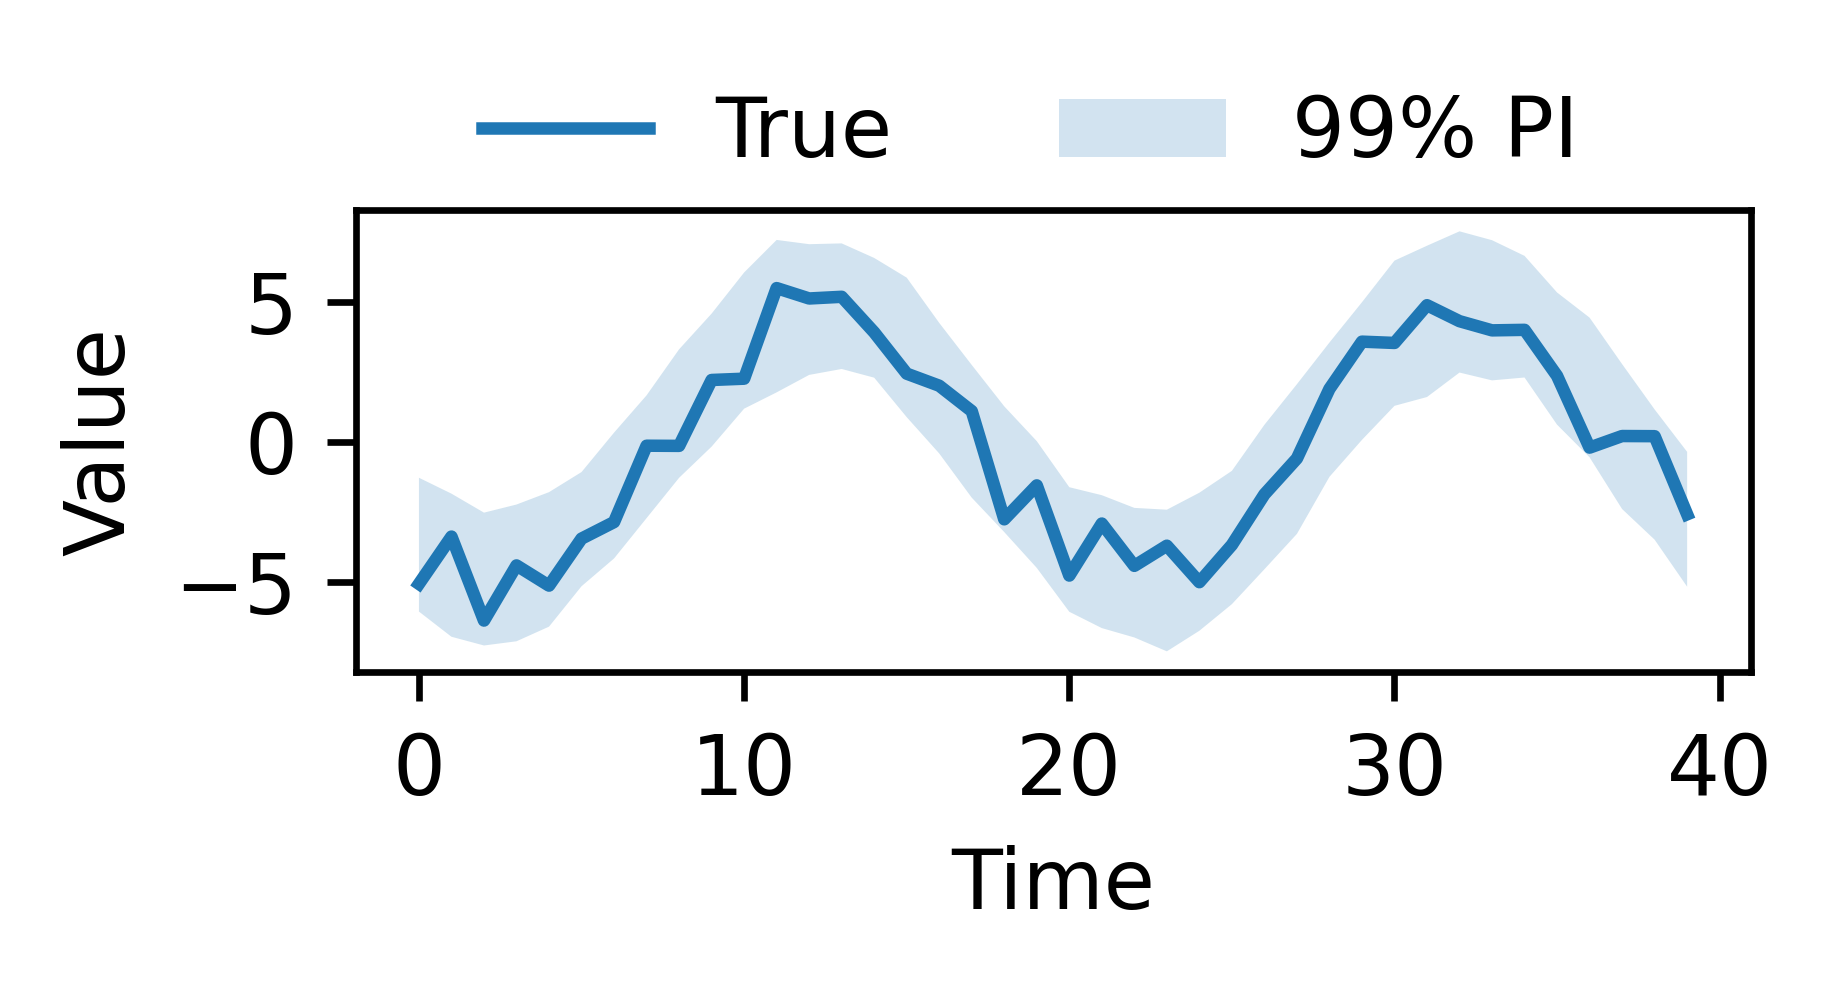

In [34]:
f_q = create_prediction_plot_quantile(20, 1, forecast_horizon, target_test, quantile_predictions_dict, target_scaler)

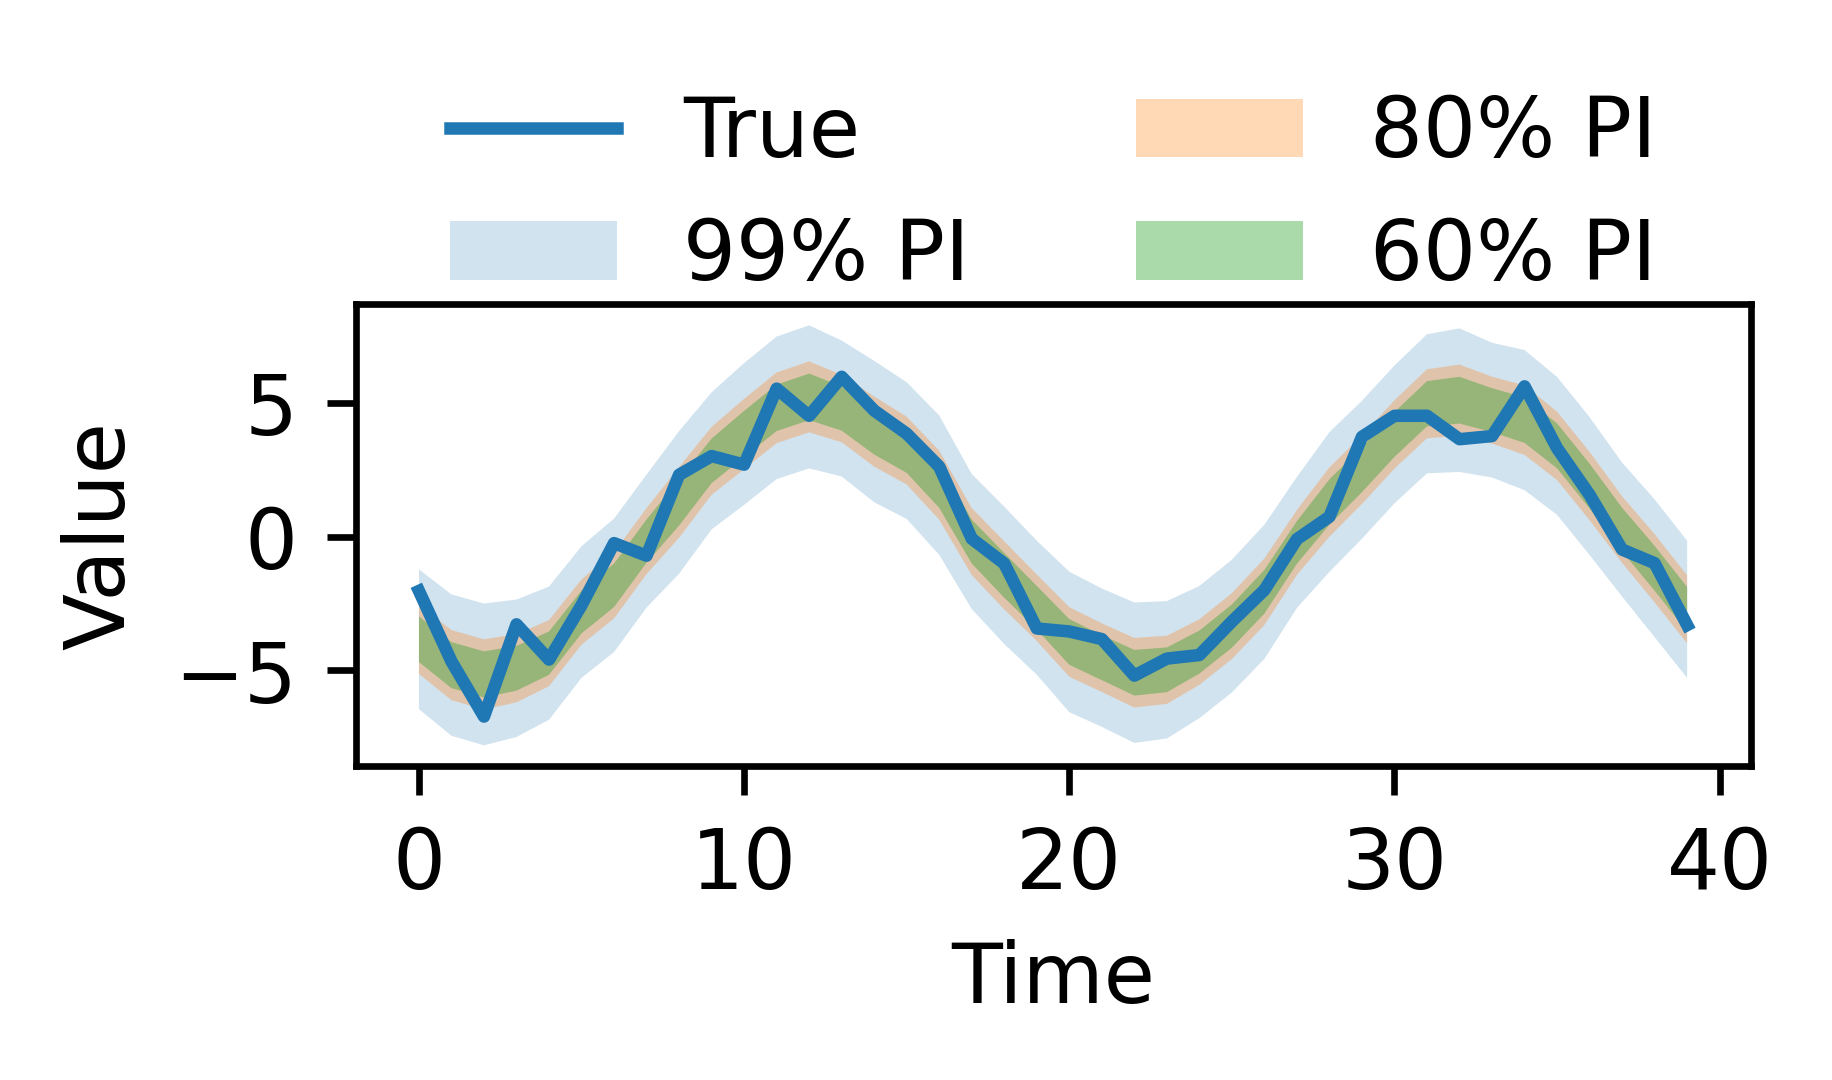

In [35]:
f = create_prediction_plot(500, 1, forecast_horizon, target_test, mu_test_history, logvar_test_history, target_scaler)

## Create and Investigate Attributions
Now we create and investigate the attributions

In [36]:
sample_to_consider = 10
step_used = 20
stacked_indexes_to_consider = np.arange(0,1000,1)
stacked_explainer_dict = dict({"Saliency": Saliency(model_history),
                               "IG": IntegratedGradients(model_history, multiply_by_inputs=False)})

In [ ]:
quantile_sample_attribution_plot = quantile_explain_plot_sample(model_dict=quantile_model_dict,
                                       sample=sample_to_consider,
                                       fh=forecast_horizon,
                                       history=history_test,
                                       hl=history_length,
                                       scaler=history_scaler)
gaussian_sample_attribution_plot = gaussian_explaination_plot_sample(model=model_history,
                                          sample=sample_to_consider,
                                          fh=forecast_horizon,
                                          history=history_test,
                                          hl=history_length,
                                          scaler=history_scaler)

In [38]:
stacked_exp = create_stacked_explainations(explainer_dict=stacked_explainer_dict,
                                           indexes=stacked_indexes_to_consider,
                                           fh=forecast_horizon,
                                           history=history_test)

In [ ]:
mean_plots_dict = dict()
for start in [0,5,13,17]:
    mean_plots_dict[start] = plot_mean_specific_time(stacked_explainer_dict=stacked_exp,
                                                     indexes=stacked_indexes_to_consider,
                                                     history=history_test,
                                                     step=step_used,
                                                     start=start,
                                                     scaler=history_scaler)

## Analyse and save Figures
Now we analyse and save the figures for the attributions

In [4]:
save_base = "Figures/synthetic/"
isExist = os.path.exists(save_base)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(save_base)
base_frequency = 0.05
if base_frequency == 0.05:
    save_figure_path = save_base
elif base_frequency == 0.1:
    save_figure_path = f"{save_base}DoubleFrequency"

In [41]:
for key, item in quantile_sample_attribution_plot.items():
    quantile_sample_attribution_plot[key].savefig(f"{save_figure_path}Quantile_sample{sample_to_consider}_{key}.pdf", format="pdf", bbox_inches="tight")

In [42]:
for key, item in gaussian_sample_attribution_plot.items():
    gaussian_sample_attribution_plot[key].savefig(f"{save_figure_path}Gaussian_sample{sample_to_consider}_{key}.pdf", format="pdf", bbox_inches="tight")

In [43]:
for start in (0,5,13,17):
    for key in stacked_exp.keys():
        mean_plots_dict[start][key].savefig(f"{save_figure_path}Mean_Gaussian_Start{start}_{key}.pdf", format="pdf", bbox_inches="tight")

## Compare Explanations Methods
Finally we compare the different attribution based explanation methods

In [44]:
all_indexes_to_compare = np.arange(0,1800,1)
sample_to_consider = 10

In [ ]:
scaled_explain, diff_dict, fig_dict = compare_mean_scaled_attributions(model=model_history,
                                      indexes_to_compare=all_indexes_to_compare,
                                      fh=forecast_horizon,
                                      history=history_test)

In [ ]:
scaled_explain_plot = plot_scaled_attribute_sample(scaled_explain=scaled_explain,
                                                   sample=sample_to_consider,
                                                   fh=forecast_horizon,
                                                   hl=history_length,
                                                   history=history_test,
                                                   scaler=history_scaler)

In [47]:
for key, item in scaled_explain_plot.items():
    scaled_explain_plot[key].savefig(f"{save_figure_path}Scaled_Gaussian_Start{sample_to_consider}_{key}.pdf", format="pdf", bbox_inches="tight")

In [48]:
for key, item in fig_dict.items():
    fig_dict[key].savefig(f"{save_figure_path}Compare_Attributions_{key}.pdf", format="pdf", bbox_inches="tight")